In [1]:
def generate_2d_corn_cluster(size, probability):
    mid = int(size / 2)

    current_step_set = set()


    current_step_set.add((mid + 1, mid))
    current_step_set.add((mid - 1, mid))
    current_step_set.add((mid, mid + 1))

    arr = np.zeros((size, size), float)
    arr[mid][mid] = 1
    next_step_set = current_step_set

    while len(next_step_set) != 0:
        next_set = set()
        for each in next_step_set:
            if random.random() < probability:
                arr[each[0]][each[1]] = 1
                if each[0] != (size - 1) and arr[each[0] + 1][each[1]] == 0:
                    next_set.add((each[0] + 1, each[1]))
                if each[0] != 0 and arr[each[0] - 1][each[1]] == 0:
                    next_set.add((each[0] - 1, each[1]))
                if each[1] != (size - 1) and arr[each[0]][each[1] + 1] == 0:
                    next_set.add((each[0], each[1] + 1))
                if each[1] != 0 and arr[each[0]][each[1] - 1] == 0:
                    next_set.add((each[0], each[1] - 1))

        next_step_set = next_set

    final_cube = np.zeros((size, size), int)

    for i in range(size):
        for j in range(size):
            final_cube[i][j] = True if arr[i][j] == 1 else False

    return final_cube


In [2]:

def expand_existing_cluster_with_shell(_grid, nucleus_size, shell_size, shell_probability):
    scale = nucleus_size + shell_size + shell_size
    current_size = _grid[0].size
    new_size = _grid[0].size * scale
    center_bias = m.floor(scale / 2)
    nucleus_r = m.floor(nucleus_size / 2)

    new_grid = np.zeros((new_size, new_size), int)

    for i in range(current_size):
        for j in range(current_size):
            if _grid[i][j] == 1:
                left_shell_border = j * scale + center_bias - nucleus_r - shell_size
                right_shell_border = j * scale + center_bias + nucleus_r + shell_size + 1
                top_shell_border = i * scale + center_bias - nucleus_r
                bot_shell_border = i * scale + center_bias + nucleus_r + 1

                for k in range(i * scale + center_bias - nucleus_r, i * scale + center_bias + nucleus_r + 1):
                    for n in range(j * scale + center_bias - nucleus_r, j * scale + center_bias + nucleus_r + 1):
                        new_grid[k][n] = 1

                for n in range(1, shell_size + 1):
                    for k in range(left_shell_border, right_shell_border):
                        if random.random() > shell_probability:
                            top_border_row = i * scale + center_bias - nucleus_r - n
                            new_grid[top_border_row][k] = 1

                        if random.random() > shell_probability:
                            bot_border_row = i * scale + center_bias + nucleus_r + n
                            new_grid[bot_border_row][k] = 1

                for n in range(1, shell_size + 1):
                    for k in range(top_shell_border, bot_shell_border):
                        if random.random() > shell_probability:
                            left_border_col = j * scale + center_bias - nucleus_r - n
                            new_grid[k][left_border_col] = 1
                        if random.random() > shell_probability:
                            right_border_col = j * scale + center_bias + nucleus_r + n
                            new_grid[k][right_border_col] = 1

    return new_grid


In [3]:
def prepare_cluster_for_splitting(grid):
    for i in range(grid[0].size):
        for j in range(grid[0].size):
            if grid[i][j] != 0:
                grid[i][j] = -1

    return grid

In [4]:
def draw_array_as_grid(figure, grid):
    plt.figure(figure)

    values = np.unique(grid)
    for i in range(len(values)):
        grid = np.where(grid == values[i], i, grid)

    max_val = grid.max(initial=None)

    if max_val != 0:
        grid = np.divide(grid, max_val)

    plt.imshow(grid, cmap='binary', vmin=0, vmax=1)


In [25]:

def split_on_clusters(grid):
    grid_len = len(grid)
    last_cluster_number = 1
    NOT_CHECKED = -1
    cluster_dict = {}

    for i in range(0, grid_len):
        for j in range(0, grid_len):
            if grid[i][j] == NOT_CHECKED:
                is_top_busy = False
                is_left_busy = False

                if j > 0: is_left_busy = grid[i][j - 1] > 0

                if i > 0: is_top_busy = grid[i - 1][j] > 0

                if is_left_busy & is_top_busy:
                    top_val = grid[i - 1][j]
                    left_val = grid[i][j - 1]
                    if top_val != left_val:
                        top_cluster = cluster_dict[top_val]
                        left_cluster = cluster_dict[left_val]
                        if len(left_cluster) > len(top_cluster):
                            for each in top_cluster:
                                grid[each[0]][each[1]] = left_val
                                left_cluster.append(each)
                            del cluster_dict[top_val]
                            left_cluster.append((i, j))
                            cluster_dict[left_val] = left_cluster
                            grid[i][j] = left_val
                        else:
                            for each in left_cluster:
                                grid[each[0]][each[1]] = top_val
                                top_cluster.append(each)
                            del cluster_dict[left_val]
                            top_cluster.append((i, j))
                            cluster_dict[top_val] = top_cluster
                            grid[i][j] = top_val
                    else:
                        cluster = cluster_dict[grid[i][j - 1]]
                        cluster.append((i, j))
                        cluster_dict[grid[i][j - 1]] = cluster
                        grid[i][j] = grid[i][j - 1]
                elif is_left_busy:
                    grid[i][j] = grid[i][j - 1]
                    val = grid[i][j]
                    cluster = cluster_dict[grid[i][j]]
                    cluster.append((i, j))
                    cluster_dict[val] = cluster
                elif is_top_busy:
                    grid[i][j] = grid[i - 1][j]
                    val = grid[i][j]
                    cluster = cluster_dict[grid[i][j]]
                    cluster.append((i, j))
                    cluster_dict[val] = cluster
                else:
                    grid[i][j] = last_cluster_number
                    new_cluster = [(i, j)]
                    cluster_dict[grid[i][j]] = new_cluster
                    last_cluster_number += 1

    keys = list(cluster_dict.keys())
    new_cluster_dict = {}

    for i in range(len(keys)):
        arr = cluster_dict[keys[i]]
        for each in arr:
            grid[each[0]][each[1]] = i + 1
        new_cluster_dict[i + 1] = cluster_dict[keys[i]]

    return new_cluster_dict


In [26]:
def drop_cluster_lower_than(grid, dictionary, lowest: int):
    values, counts = np.unique(grid, return_counts=True)

    for i in range(1, len(values)):
        if counts[i] < lowest:
            grid = np.where(grid == values[i], 0, grid)
            del dictionary[values[i]]

    values = np.unique(grid)
    for i in range(len(values)):
        grid = np.where(grid == values[i], i, grid)

    return grid, dictionary


In [27]:
import numpy as np
import random
import math as m
import matplotlib.pyplot as plt

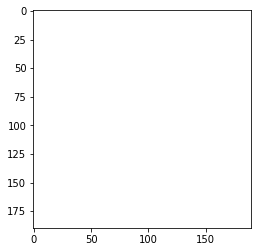

In [29]:
grid_size = 10

nucleus_probability = 0.6
shell_probability = 0.7

nucleus_size = 15
shell_size = 2

cluster_size_to_drop = 5

grid = generate_2d_corn_cluster(grid_size, nucleus_probability)
res_grid = expand_existing_cluster_with_shell(grid, nucleus_size, shell_size, shell_probability)
res_grid = prepare_cluster_for_splitting(res_grid)
res_grid_dict = split_on_clusters(res_grid)
only_large_clusters, only_large_clusters_dict = drop_cluster_lower_than(res_grid,
                                                                          res_grid_dict,
                                                                          nucleus_size ** 2 * cluster_size_to_drop)
draw_array_as_grid('some', only_large_clusters)

plt.show()
